In [ ]:
import math
import torch
import scipy.special as sc
from scipy.stats import chi2
import random
import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@torch.no_grad()
def _invSqrt(A):
        vals, vecs = torch.linalg.eigh(A)
        return vecs @ torch.diag(1.0 / torch.sqrt(vals)) @ vecs.T

@torch.no_grad()
def rTensorNorm(n, M, Sigma1, Sigma2, Sigma3):
    p1 = Sigma1.shape[0]
    p2 = Sigma2.shape[0]
    p3 = Sigma3.shape[0]
    e1_vals, e1_vecs = torch.linalg.eigh(Sigma1)
    sqrtSigma1 = e1_vecs @ torch.diag(torch.sqrt(e1_vals)) @ e1_vecs.T
    e2_vals, e2_vecs = torch.linalg.eigh(Sigma2)
    sqrtSigma2 = e2_vecs @ torch.diag(torch.sqrt(e2_vals)) @ e2_vecs.T
    e3_vals, e3_vecs = torch.linalg.eigh(Sigma3)
    sqrtSigma3 = e3_vecs @ torch.diag(torch.sqrt(e3_vals)) @ e3_vecs.T
    Z = torch.randn(n, p1, p2, p3, device=device)
    Z = Z.view(n * p1 * p2, p3) @ sqrtSigma3
    Z = Z.view(n, p1, p2, p3)
    Z = Z.permute(0, 1, 3, 2).contiguous()
    Z = Z.view(n * p1 * p3, p2) @ sqrtSigma2
    Z = Z.view(n, p1, p3, p2)
    Z = Z.permute(0, 3, 2, 1).contiguous()
    Z = Z.view(n * p2 * p3, p1) @ sqrtSigma1
    Z = Z.view(n, p2, p3, p1)
    Z = Z.permute(0, 3, 1, 2).contiguous()
    M_expanded = M.unsqueeze(0).expand(n, p1, p2, p3)
    Z = Z + M_expanded
    return Z

@torch.no_grad()
def computeTensorMD(C, invSqrt1, invSqrt2, invSqrt3, returnContributions=False):
    n, p1, p2, p3 = C.shape
    C = C.view(n * p1 * p2, p3) @ invSqrt3
    C = C.view(n, p1, p2, p3)
    C = C.permute(0, 1, 3, 2).contiguous()
    C = C.view(n * p1 * p3, p2) @ invSqrt2
    C = C.view(n, p1, p3, p2)
    C = C.permute(0, 3, 2, 1).contiguous()
    C = C.view(n * p2 * p3, p1) @ invSqrt1
    C = C.view(n, p2, p3, p1)
    C = C.permute(0, 3, 1, 2).contiguous()
    D = C * C
    D = D.view(n, -1)
    TMDsq = D.sum(dim=1)
    if returnContributions:
        D = D.view(n, p1, p2, p3)
        return TMDsq, D
    else:
        return TMDsq

@torch.no_grad()
def updateOneCov(C, invSqrt2, invSqrt3):
    n, p1, p2, p3 = C.shape
    C = C.view(n * p1 * p2, p3) @ invSqrt3
    C = C.view(n, p1, p2, p3)
    C = C.permute(0, 1, 3, 2).contiguous()
    C = C.view(n * p1 * p3, p2) @ invSqrt2
    C = C.view(n, p1, p3, p2)
    C = C.permute(1, 0, 3, 2).contiguous()
    C = C.view(p1, n * p2 * p3)
    Sigma1 = (C @ C.T) / (n * p2 * p3)
    return Sigma1





@torch.no_grad()
def flipFlopMLE(C1, C2, C3,
                Sigma1init, Sigma2init, Sigma3init,
                invSqrt2init, invSqrt3init,
                maxIter,
                tol):

    old1 = Sigma1init
    old2 = Sigma2init
    old3 = Sigma3init
    invSqrt2 = invSqrt2init
    invSqrt3 = invSqrt3init
    for it in range(maxIter):
        Sigma1 = updateOneCov(C1, invSqrt2, invSqrt3)
        invSqrt1 = _invSqrt(Sigma1)
        Sigma2 = updateOneCov(C2, invSqrt3, invSqrt1)
        invSqrt2 = _invSqrt(Sigma2)
        Sigma3 = updateOneCov(C3, invSqrt1, invSqrt2)
        d11_1 = Sigma1[0, 0]
        d11_2 = Sigma2[0, 0]
        Sigma1 = Sigma1 / d11_1
        Sigma2 = Sigma2 / d11_2
        Sigma3 = Sigma3 * (d11_1 * d11_2)
        if it == maxIter - 1:
            break
        frobDiff = torch.sum((Sigma1 - old1) ** 2) \
                 + torch.sum((Sigma2 - old2) ** 2) \
                 + torch.sum((Sigma3 - old3) ** 2)
        if frobDiff < tol:
            break
        invSqrt3 = _invSqrt(Sigma3)
        old1 = Sigma1
        old2 = Sigma2
        old3 = Sigma3
    return {
        "Sigma1": Sigma1,
        "Sigma2": Sigma2,
        "Sigma3": Sigma3,
        "invSqrt1": invSqrt1,
        "invSqrt2": invSqrt2
    }

@torch.no_grad()
def cStep(X, C, Sigma1, Sigma2, Sigma3,
          invSqrt1, invSqrt2, invSqrt3,
          alpha,
          maxIterC,
          tolC,
          maxIterFF,
          tolFF):
    def _ld(S1, S2, S3):
        return (p2 * p3) * torch.logdet(S1) \
             + (p1 * p3) * torch.logdet(S2) \
             + (p1 * p2) * torch.logdet(S3)
    n, p1, p2, p3 = X.shape
    h = int(math.floor(alpha * n))
    ldOld = _ld(Sigma1, Sigma2, Sigma3)
    for it in range(maxIterC):
        TMDsAll = computeTensorMD(C, invSqrt1, invSqrt2, invSqrt3)
        sortedIdx = torch.argsort(TMDsAll)
        subsetIndices = sortedIdx[:h]
        Xsub = X[subsetIndices]
        subMean = Xsub.mean(dim=0)
        C1 = Xsub - subMean
        C2 = C1.permute(0, 2, 3, 1).contiguous()
        C3 = C1.permute(0, 3, 1, 2).contiguous()
        initFF = flipFlopMLE(
            C1, C2, C3,
            Sigma1, Sigma2, Sigma3,
            invSqrt2, invSqrt3,
            maxIterFF,
            tolFF
        )
        Sigma1 = initFF["Sigma1"]
        Sigma2 = initFF["Sigma2"]
        Sigma3 = initFF["Sigma3"]
        invSqrt1 = initFF["invSqrt1"]
        invSqrt2 = initFF["invSqrt2"]
        ldNew = _ld(Sigma1, Sigma2, Sigma3)
        if it == maxIterC - 1 or abs(ldNew - ldOld) < tolC:
            break
        ldOld = ldNew
        C = X - subMean
        vals, vecs = torch.linalg.eigh(Sigma3)
        invSqrt3 = vecs @ torch.diag(1.0 / torch.sqrt(vals)) @ vecs.T
    return {
        "Sigma1": Sigma1,
        "Sigma2": Sigma2,
        "Sigma3": Sigma3,
        "invSqrt1": invSqrt1,
        "invSqrt2": invSqrt2,
        "subsetIndices": subsetIndices,
        "TMDsAll": TMDsAll,
        "ld": ldNew
    }

@torch.no_grad()
def tmcd(X,
         alpha,
         nSubsets,
         nBest,
         maxIterCshort,
         maxIterFFshort,
         maxIterCfull,
         maxIterFFfull,
         tolC,
         tolFF,
         beta):

    n, p1, p2, p3 = X.shape
    s = int(math.ceil(p1/(p2*p3) + p2/(p1*p3) + p3/(p1*p2))) + 2
    allSubsets = []
    for _ in range(nSubsets):
        allSubsets.append(torch.randperm(n)[:s].to(device))
    shortResults = []
    for i in range(nSubsets):
        idx = allSubsets[i]
        xSub = X[idx]
        subMean = xSub.mean(dim=0)
        C1 = xSub - subMean
        C2 = C1.permute(0, 2, 3, 1).contiguous()
        C3 = C1.permute(0, 3, 1, 2).contiguous()
        initSig1 = torch.eye(p1, device=device)
        initSig2 = torch.eye(p2, device=device)
        initSig3 = torch.eye(p3, device=device)
        initInvSqrt2 = torch.eye(p2, device=device)
        initInvSqrt3 = torch.eye(p3, device=device)
        shortMLE = flipFlopMLE(
            C1, C2, C3,
            initSig1, initSig2, initSig3,
            initInvSqrt2, initInvSqrt3,
            maxIterFFshort,
            tolFF
        )
        C = X - subMean
        curInvSqrt3 = _invSqrt(shortMLE["Sigma3"])
        shortRes = cStep(
            X, C,
            shortMLE["Sigma1"],
            shortMLE["Sigma2"],
            shortMLE["Sigma3"],
            shortMLE["invSqrt1"],
            shortMLE["invSqrt2"],
            curInvSqrt3,
            alpha,
            maxIterCshort,
            tolC,
            maxIterFFshort,
            tolFF
        )
        shortResults.append(shortRes)
    allLd = torch.tensor([res["ld"] for res in shortResults], device=device)
    rankLd = torch.argsort(allLd)
    topIdx = rankLd[:min(nBest, nSubsets)]
    fullResults = []
    for j in range(len(topIdx)):
        chosen = shortResults[topIdx[j]]
        xSub = X[chosen["subsetIndices"]]
        subMean = xSub.mean(dim=0)
        C = X - subMean
        invSqrt3 = _invSqrt(chosen["Sigma3"])
        fullRes = cStep(
            X, C,
            chosen["Sigma1"],
            chosen["Sigma2"],
            chosen["Sigma3"],
            chosen["invSqrt1"],
            chosen["invSqrt2"],
            invSqrt3,
            alpha,
            maxIterCfull,
            tolC,
            maxIterFFfull,
            tolFF
        )
        fullResults.append(fullRes)
    allLdFull = torch.tensor([r["ld"] for r in fullResults], device=device)
    bestFullIdx = torch.argmin(allLdFull)
    bestRaw = fullResults[bestFullIdx]
    dfMain = p1 * p2 * p3
    dfPlus = dfMain + 2
    chiAlpha = chi2.ppf(alpha, dfMain)
    cdfVal = chi2.cdf(chiAlpha, dfPlus)
    gammaAlpha = alpha / cdfVal
    S1 = bestRaw["Sigma1"]
    S2 = bestRaw["Sigma2"]
    S3 = bestRaw["Sigma3"] * gammaAlpha
    invSqrt2 = bestRaw["invSqrt2"]
    vals3, vecs3 = torch.linalg.eigh(S3)
    invSqrt3 = vecs3 @ torch.diag(1.0 / torch.sqrt(vals3)) @ vecs3.T
    TMDsqAll = bestRaw["TMDsAll"]
    cutoff = chi2.ppf(beta, dfMain)
    goodSet = torch.where((TMDsqAll / gammaAlpha) < cutoff)[0]
    finalGood = torch.unique(torch.cat([bestRaw["subsetIndices"], goodSet]))
    outliers = torch.tensor(list(set(range(n)) - set(finalGood.tolist())), device=device)
    Xgood = X[finalGood]
    M = Xgood.mean(dim=0)
    alphaHat = float(len(finalGood)) / n
    C1 = Xgood - M
    C2 = C1.permute(0, 2, 3, 1).contiguous()
    C3 = C1.permute(0, 3, 1, 2).contiguous()
    ffFinal = flipFlopMLE(
        C1, C2, C3,
        S1, S2, S3,
        invSqrt2, invSqrt3,
        maxIterFFfull,
        tolFF
    )
    S1 = ffFinal["Sigma1"]
    S2 = ffFinal["Sigma2"]
    S3 = ffFinal["Sigma3"]
    chiAlphaHat = chi2.ppf(alphaHat, dfMain)
    cdfValHat = chi2.cdf(chiAlphaHat, dfPlus)
    gammaAlphaHat = alphaHat / cdfValHat
    S3 = S3 * gammaAlphaHat
    return {
        "M": M,
        "Sigma1": S1,
        "Sigma2": S2,
        "Sigma3": S3,
        "outliers": outliers,
        "finalGood": finalGood
    }



In [ ]:
# *** LOAD DATASET ************************************************************
import time, os, zipfile, math, torch, numpy as np, matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from matplotlib import font_manager

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
zip_path = "/content/tensor_dataset_sea.zip"                      # <-- put zip here
assert os.path.exists(zip_path), "tensor_dataset_sea.zip not found!"

with zipfile.ZipFile(zip_path, "r") as zf:                        # unpack
    zf.extractall("/content")

dataset_uint8 = torch.load("/content/tensor_dataset_bigShip.pt", map_location="cpu")
X_full        = (dataset_uint8.to(torch.float32) / 255.).to(device).contiguous()
n, p1, p2, p3 = X_full.shape
print(f"Loaded dataset  : {n} clips  ({p1}×{p2}×{p3})\n")

Loaded dataset  : 330 clips  (144×256×80)



In [ ]:
# remove every 4‑th frame (0‑based → drop 0,4,8,…)
idx  = torch.arange(X_full.size(-1), device=X_full.device)
mask = (idx % 4) != 0                     # keep frames whose index mod 4 ≠ 0
X_full = X_full[..., mask].contiguous()

n, p1, p2, p3 = X_full.shape
print(f"After dropping every 4‑th frame : {n} clips  ({p1}×{p2}×{p3})\n")


After dropping every 4‑th frame : 330 clips  (144×256×60)



In [ ]:
# merge every 3 consecutive clips into one longer clip ------------------------
n, p1, p2, p3 = X_full.shape
n_new = n // 3                              # complete triplets only
if n % 3:
    print(f"⚠️ dropping last {n % 3} clip(s) – not enough for a full triplet")

# (n_new, 3, H, W, T) → concatenate along time axis → (n_new, H, W, 3T)
X_full = (X_full[:n_new*3]                          # cut tail if any
          .view(n_new, 3, p1, p2, p3)
          .permute(0, 2, 3, 1, 4)                   # 0,nw→0; H→1; W→2; triplet→3; T→4
          .contiguous()
          .view(n_new, p1, p2, p3 * 3))             # flatten last two dims

n, p1, p2, p3 = X_full.shape
print(f"After merging triplets : {n} clips  ({p1}×{p2}×{p3})\n")


After merging triplets : 110 clips  (144×256×180)



In [ ]:
# *** TMCD ********************************************************************
start = time.perf_counter()
tmcd_res = tmcd(
    X_full,
    alpha          = 0.6,
    nSubsets       = 500,
    nBest          = 20,
    maxIterCshort  = 2,
    maxIterFFshort = 2,
    maxIterCfull   = 50,
    maxIterFFfull  = 100,
    tolC           = 1e-4,
    tolFF          = 1e-3,
    beta           = 0.9999
)
if torch.cuda.is_available():
    torch.cuda.synchronize()
elapsed = time.perf_counter() - start

good      = tmcd_res["finalGood"].numel()
outliers  = sorted(tmcd_res["outliers"].cpu().tolist())
print(f"TMCD finished   – good clips: {good}/{n}")
print(f"Elapsed time    : {elapsed:.2f}s")
print(f"Outlier indices : {outliers}\n")

TMCD finished   – good clips: 66/110
Elapsed time    : 460.37s
Outlier indices : [1, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 30, 43, 44, 46, 47, 48, 49, 56, 60, 61, 67, 68, 69, 70, 73, 80, 81, 83, 85, 87, 101, 104, 105, 108]



Top‑10 clips (desc): [(tensor(61), 4524802560.0), (tensor(62), 3660232704.0), (tensor(48), 111433056.0), (tensor(11), 63228596.0), (tensor(81), 44153896.0), (tensor(20), 38625428.0), (tensor(68), 33203382.0), (tensor(44), 31635768.0), (tensor(6), 30529418.0), (tensor(12), 27341650.0)]


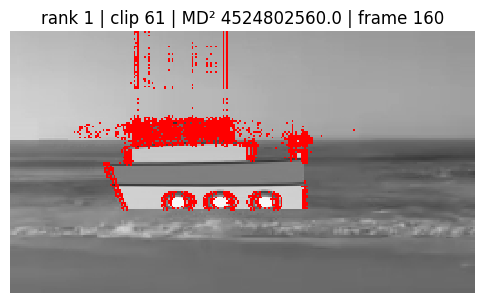

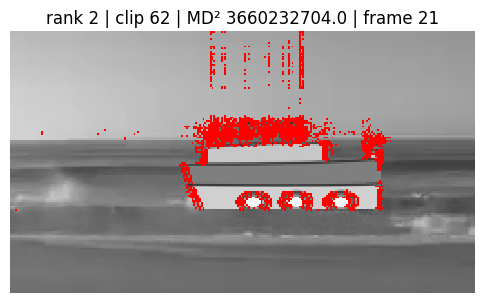

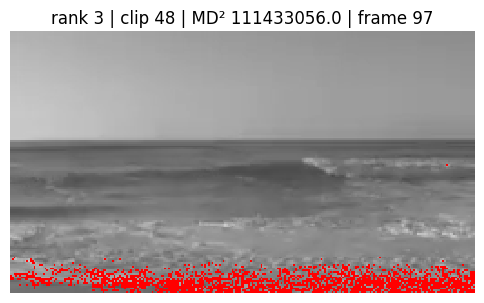

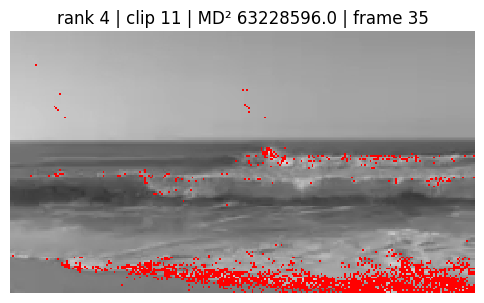

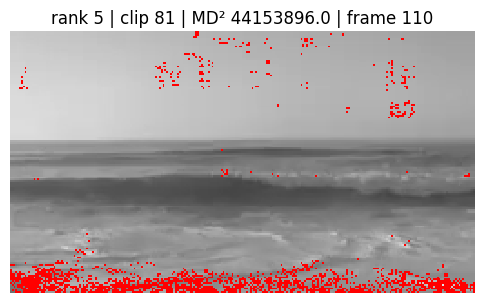

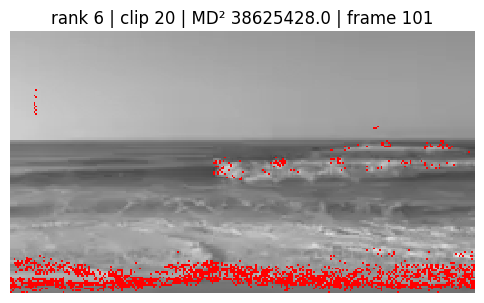

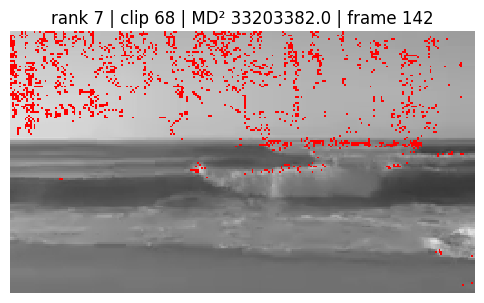

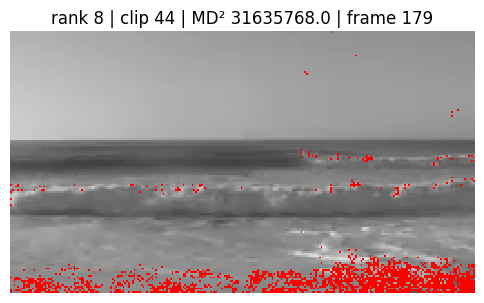

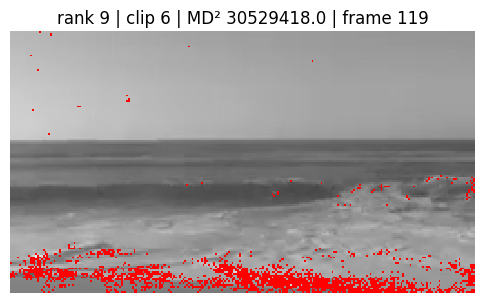

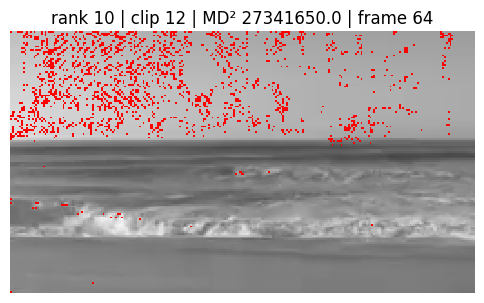

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt

# Mahalanobis distances --------------------------------------------------------
invSqrt1 = _invSqrt(tmcd_res["Sigma1"])
invSqrt2 = _invSqrt(tmcd_res["Sigma2"])
invSqrt3 = _invSqrt(tmcd_res["Sigma3"])

with torch.no_grad():
    TMDsq_all = computeTensorMD(X_full, invSqrt1, invSqrt2, invSqrt3).cpu()

# top‑10 observations by descending MD²
top_md2, top_idx = torch.topk(TMDsq_all, k=10, largest=True, sorted=True)

print("Top‑10 clips (desc):", [(i+1, round(md.item(),1)) for i, md in zip(top_idx, top_md2)])

for rank, (idx, md2) in enumerate(zip(top_idx.tolist(), top_md2.tolist()), 1):

    clip = X_full[idx]
    _, D = computeTensorMD((clip - tmcd_res["M"]).unsqueeze(0),
                           invSqrt1, invSqrt2, invSqrt3,
                           returnContributions=True)
    D       = D.squeeze(0)
    j_star  = torch.argmax(D.sum(dim=(0,1))).item()      # frame most “contaminated”
    mask    = D[..., j_star] >= torch.quantile(D[..., j_star], 0.95)  # critical: top 5 % pixels
    frame   = clip[..., j_star].cpu().numpy()
    rgb     = np.stack([frame]*3, axis=-1)
    rgb[mask.cpu().numpy()] = [1., 0., 0.]

    plt.figure(figsize=(6, 3.5))
    plt.imshow(rgb, interpolation="nearest")
    plt.title(f"rank {rank} | clip {idx+1} | MD² {md2:.1f} | frame {j_star+1}")
    plt.axis("off")
    plt.show()


In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np, torch, math
from matplotlib import font_manager

alpha = 0.3
ttf   = font_manager.findfont("DejaVu Sans")
font  = ImageFont.truetype(ttf, size=12)

invSqrt1 = _invSqrt(tmcd_res["Sigma1"])
invSqrt2 = _invSqrt(tmcd_res["Sigma2"])
invSqrt3 = _invSqrt(tmcd_res["Sigma3"])

def overlay_frame(idx, md2):
    # most-contaminated frame in clip -----------------------------------------
    clip = X_full[idx]
    _, D = computeTensorMD((clip - tmcd_res["M"]).unsqueeze(0),
                           invSqrt1, invSqrt2, invSqrt3,
                           returnContributions=True)
    D       = D.squeeze(0)
    j_star  = torch.argmax(D.sum(dim=(0,1))).item()
    mask    = D[..., j_star] >= torch.quantile(D[..., j_star], 0.95)

    frame = clip[..., j_star].cpu().numpy()
    rgb   = np.stack([frame]*3, axis=-1)
    rgb[mask.cpu().numpy()] = (1-alpha)*rgb[mask.cpu().numpy()] + alpha*np.array([1,0,0])

    img  = Image.fromarray((rgb*255).astype(np.uint8))
    draw = ImageDraw.Draw(img)
    label = f"clip {idx+1} | frame {j_star+1} | MD² {md2:.2e}"
    w,h   = draw.textbbox((0,0), label, font=font)[2:]
    draw.rectangle([(0, img.height-h-2), (w+4, img.height)], fill=(0,0,0))
    draw.text((2, img.height-h-1), label, fill="white", font=font)
    return img

imgs = [overlay_frame(i, md) for i, md in zip(top_idx.tolist(), top_md2.tolist())]

h, w = imgs[0].size[1], imgs[0].size[0]
cols = 2
rows = math.ceil(len(imgs)/cols)
canvas = Image.new("RGB", (w*cols, h*rows))
for k, im in enumerate(imgs):
    r,c = divmod(k, cols)
    canvas.paste(im, (c*w, r*h))

pdf_path = "/content/top10_md2_outliers.pdf"
canvas.save(pdf_path, "PDF")
print("saved:", pdf_path)


saved: /content/top10_md2_outliers.pdf


In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np, torch, math
from matplotlib import font_manager

alpha = 0.3                                        # red overlay opacity
txt_alpha = 200                                    # 0–255, text transparency
ttf   = font_manager.findfont("DejaVu Sans")
font  = ImageFont.truetype(ttf, size=12)

invSqrt1 = _invSqrt(tmcd_res["Sigma1"])
invSqrt2 = _invSqrt(tmcd_res["Sigma2"])
invSqrt3 = _invSqrt(tmcd_res["Sigma3"])

def overlay_frame(idx, md2):
    # frame with max contribution --------------------------------------------
    clip = X_full[idx]
    _, D = computeTensorMD((clip - tmcd_res["M"]).unsqueeze(0),
                           invSqrt1, invSqrt2, invSqrt3,
                           returnContributions=True)
    D       = D.squeeze(0)
    j_star  = torch.argmax(D.sum(dim=(0,1))).item()
    mask    = D[..., j_star] >= torch.quantile(D[..., j_star], 0.95)

    frame = clip[..., j_star].cpu().numpy()
    rgb   = np.stack([frame]*3, axis=-1)
    rgb[mask.cpu().numpy()] = (1-alpha)*rgb[mask.cpu().numpy()] + alpha*np.array([1,0,0])

    base = Image.fromarray((rgb*255).astype(np.uint8)).convert("RGBA")

    # transparent text layer --------------------------------------------------
    label = f"clip {idx+1} | frame {j_star+1} | MD² {md2:.2e}"
    txt   = Image.new("RGBA", base.size, (0,0,0,0))
    draw  = ImageDraw.Draw(txt)
    draw.text((2, 2),             label, fill=(0,0,0,txt_alpha), font=font)
    out = Image.alpha_composite(base, txt).convert("RGB")
    return out

imgs = [overlay_frame(i, md) for i, md in zip(top_idx.tolist(), top_md2.tolist())]

h, w = imgs[0].size[1], imgs[0].size[0]
cols = 2
rows = math.ceil(len(imgs)/cols)
canvas = Image.new("RGB", (w*cols, h*rows))
for k, im in enumerate(imgs):
    r,c = divmod(k, cols)
    canvas.paste(im, (c*w, r*h))

pdf_path = "/content/top10_md2_outliers_transp.pdf"
canvas.save(pdf_path, "PDF")
print("saved:", pdf_path)


saved: /content/top10_md2_outliers_transp.pdf


In [ ]:
import gc

for var in list(globals().values()):
    if hasattr(var, 'iterator') and hasattr(var, 'num_workers'):
        var._iterator._shutdown_workers()
for k in list(globals().keys()):
    obj = globals()[k]
    if torch.is_tensor(obj) or isinstance(obj, torch.nn.Module):
        del globals()[k]


gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
print("allocated :", torch.cuda.memory_allocated() / 1024**2, "MB")
print("reserved  :", torch.cuda.memory_reserved()  / 1024**2, "MB")


allocated : 16.90966796875 MB
reserved  : 3722.0 MB


In [ ]:
del tensors_and_models
gc.collect()
torch.cuda.empty_cache()

NameError: name 'tensors_and_models' is not defined